## Quản lý danh mục đầu tư
Nhóm chủ đề 05: Vận dụng các mô hình định giá tài sản để định giá cổ phiếu

In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
import Input_Inv as Input

%load_ext autoreload
%autoreload 2

In [3]:
tickers = ['PHR.csv','DPR.csv','TRC.csv','GVR.csv','VNIndex.csv']
port = pd.DataFrame()
for t in tickers:
    port[t] = Input.read_data(t)['Close']

In [4]:
port

,PHR.csv,DPR.csv,TRC.csv,GVR.csv,VNIndex.csv
Date,,,,,
2020-06-01,53000.0,38700.0,28300.0,12850,878.67
2020-06-02,51100.0,38100.0,28200.0,12550,874.80
2020-06-03,54500.0,38150.0,28400.0,13000,881.17
2020-06-04,53700.0,38150.0,30000.0,12700,883.90
2020-06-05,54600.0,38250.0,29500.0,12900,886.22
...,...,...,...,...,...
2023-05-26,46000.0,56300.0,28600.0,17200,1063.76
2023-05-29,46000.0,56700.0,29000.0,18200,1074.98
2023-05-30,45800.0,56500.0,NaN,18400,1078.05


## Chuẩn hóa Variables

In [5]:
port.columns = ['PHR','DPR','TRC','GVR','VNIndex']
port

,PHR,DPR,TRC,GVR,VNIndex
Date,,,,,
2020-06-01,53000.0,38700.0,28300.0,12850,878.67
2020-06-02,51100.0,38100.0,28200.0,12550,874.80
2020-06-03,54500.0,38150.0,28400.0,13000,881.17
2020-06-04,53700.0,38150.0,30000.0,12700,883.90
2020-06-05,54600.0,38250.0,29500.0,12900,886.22
...,...,...,...,...,...
2023-05-26,46000.0,56300.0,28600.0,17200,1063.76
2023-05-29,46000.0,56700.0,29000.0,18200,1074.98
2023-05-30,45800.0,56500.0,NaN,18400,1078.05


In [6]:
port_return = np.log(port/port.shift(1))
port_return.dropna(inplace=True)
port_return

,PHR,DPR,TRC,GVR,VNIndex
Date,,,,,
2020-06-02,-0.036507,-0.015625,-0.003540,-0.023623,-0.004414
2020-06-03,0.064416,0.001311,0.007067,0.035229,0.007255
2020-06-04,-0.014788,0.000000,0.054808,-0.023347,0.003093
2020-06-05,0.016621,0.002618,-0.016807,0.015625,0.002621
2020-06-08,0.001830,0.005215,0.016807,0.007722,0.015341
...,...,...,...,...,...
2023-05-19,0.040147,0.007326,0.000000,0.024923,-0.001161
2023-05-22,0.003466,0.025227,0.015666,0.015267,0.003340
2023-05-23,0.003454,-0.019767,-0.015666,-0.006079,-0.004484


In [7]:
port_Cov = port_return.cov()
port_Cov

,PHR,DPR,TRC,GVR,VNIndex
PHR,0.000711,0.000353,0.000195,0.000550,0.000244
DPR,0.000353,0.000566,0.000187,0.000406,0.000174
TRC,0.000195,0.000187,0.000788,0.000219,0.000102
GVR,0.000550,0.000406,0.000219,0.001018,0.000305
VNIndex,0.000244,0.000174,0.000102,0.000305,0.000196


In [8]:
port_Corr = port_return.corr()
port_Corr

,PHR,DPR,TRC,GVR,VNIndex
PHR,1.000000,0.556540,0.260105,0.645872,0.654304
DPR,0.556540,1.000000,0.279869,0.535593,0.522318
TRC,0.260105,0.279869,1.000000,0.244523,0.259663
GVR,0.645872,0.535593,0.244523,1.000000,0.681787
VNIndex,0.654304,0.522318,0.259663,0.681787,1.000000


In [9]:
ones_Corr = np.ones_like(port_Corr,dtype=bool)
ones_Corr

array([[ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True]])

In [10]:
mask = np.triu(ones_Corr)
mask

array([[ True,  True,  True,  True,  True],
       [False,  True,  True,  True,  True],
       [False, False,  True,  True,  True],
       [False, False, False,  True,  True],
       [False, False, False, False,  True]])

In [11]:
adjust_mask = mask[1:, :-1]
adjust_mask

array([[False,  True,  True,  True],
       [False, False,  True,  True],
       [False, False, False,  True],
       [False, False, False, False]])

In [12]:
adjust_port_Corr = port_Corr.iloc[1:, :-1]

Text(0.5, 1.0, 'Tương quan giữa từng loại tài sản trong danh mục\n')

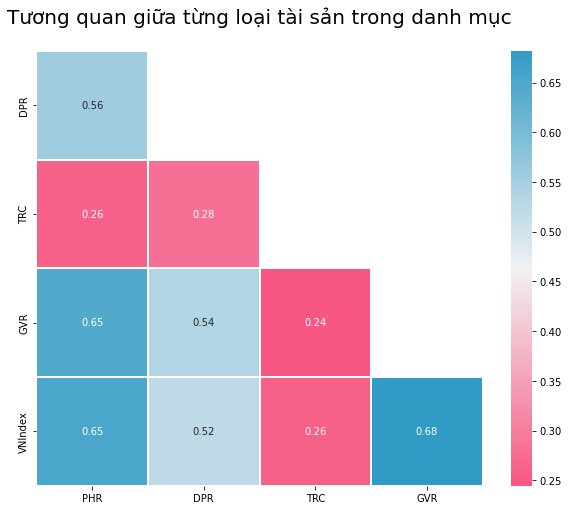

In [13]:
fig, ax = plt.subplots(figsize=(10,8))

cmap = sns.diverging_palette(0, 230, 90, 60, as_cmap=True)

sns.heatmap(data=adjust_port_Corr, mask=adjust_mask, annot=True, cmap=cmap,linecolor='White',linewidths=0.1)

title = 'Tương quan giữa từng loại tài sản trong danh mục\n'
ax.set_title(title, loc='center',fontsize=20)

In [16]:
Cov_PHR_VNIndex = port_Cov.iloc[0,4]

In [17]:
Cov_PHR_VNIndex

0.0002444067662223467

In [18]:
Cov_DPR_VNIndex = port_Cov.iloc[1,4]

In [19]:
Cov_DPR_VNIndex

0.00017399829176335804

In [20]:
Cov_TRC_VNIndex = port_Cov.iloc[2,4]

In [21]:
Cov_TRC_VNIndex

0.00010207250812557243

In [22]:
Cov_GVR_VNIndex = port_Cov.iloc[3,4]

In [23]:
Cov_GVR_VNIndex

0.0003047712012371585

In [24]:
VNIndex_Var = port_return['VNIndex'].var()

In [25]:
VNIndex_Var

0.00019621644708330132

## Tính Beta

In [27]:
PHR_Beta = Cov_PHR_VNIndex/VNIndex_Var
DPR_Beta = Cov_DPR_VNIndex/VNIndex_Var
TRC_Beta = Cov_TRC_VNIndex/VNIndex_Var
GVR_Beta = Cov_GVR_VNIndex/VNIndex_Var

## Giá trị Beta của PHR

In [28]:
PHR_Beta

1.2455977562298168

## Giá trị Beta của DPR

In [29]:
DPR_Beta

0.8867671102488629

## Giá trị Beta của TRC

In [30]:
TRC_Beta

0.5202036304440819

## Giá trị Beta của GVR

In [31]:
GVR_Beta

1.5532398316628961

## Regplot

In [32]:
y_PHR = port_return['PHR']
y_DPR = port_return['DPR']
y_TRC = port_return['TRC']
y_GVR = port_return['GVR']
x_VNIndex = port_return['VNIndex']

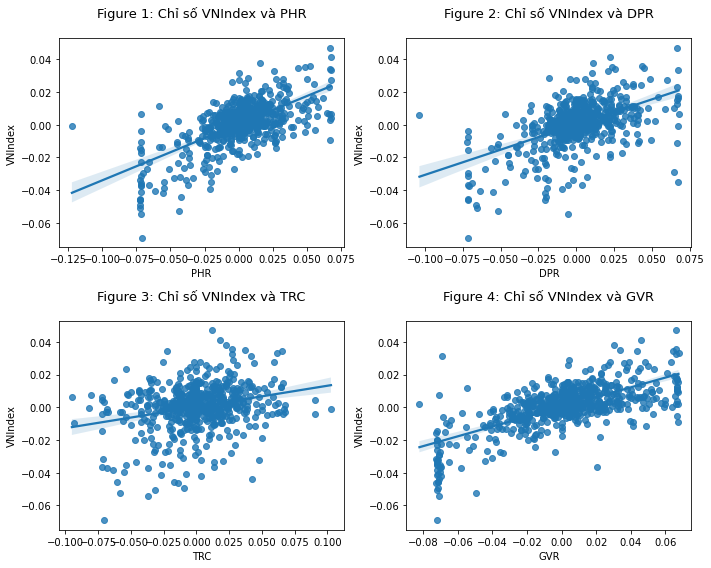

In [38]:
label = ['PHR','DPR','TRC','GVR','VNIndex']
y = 2
x = 2

fig, ax = plt.subplots(y, x, figsize =(y*5, x*4))

for r in range(0, y):
    for c in range(0, x):
        i = r*x + c
        if i < len(label):
            ax_i = ax[r,c]
            sns.regplot(data=port_return, x=label[i], y=x_VNIndex, ax=ax_i)
            ax_i.set_title(f"Figure {i+1}: Chỉ số VNIndex và {label[i]}\n", fontsize=13)
plt.tight_layout()